<a href="https://colab.research.google.com/github/horstl/ProtFlow/blob/master/examples/colab_tutorials/ProtFlow_tutorial_binderdesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use ProtFlow to design a binder

The first 3 blocks of this notebook will setup [RFDiffusion](https://github.com/RosettaCommons/RFdiffusion), [LigandMPNN](https://github.com/dauparas/LigandMPNN), [Boltz](https://github.com/jwohlwend/boltz) and [DSSP](https://github.com/PDB-REDO/dssp) (version 4.2.2). Installation might take ~15-20 mins. We recommend to start the installation right away so you have time to read through the notebook cell by cell during the install.

This tutorial shows how to use [ProtFlow](https://github.com/mabr3112/ProtFlow) to build a computational pipeline to design a binder for a protein target ([EGFR receptor](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)). You can find an extended version of this tutorial in ProtFlow's [documentation](https://protflow.readthedocs.io/en/updates-docs/tutorials/binder_design.html).
Detailed notebooks describing various design tools integrated in ProtFlow can be found [here](https://github.com/mabr3112/ProtFlow/tree/master/examples).

# 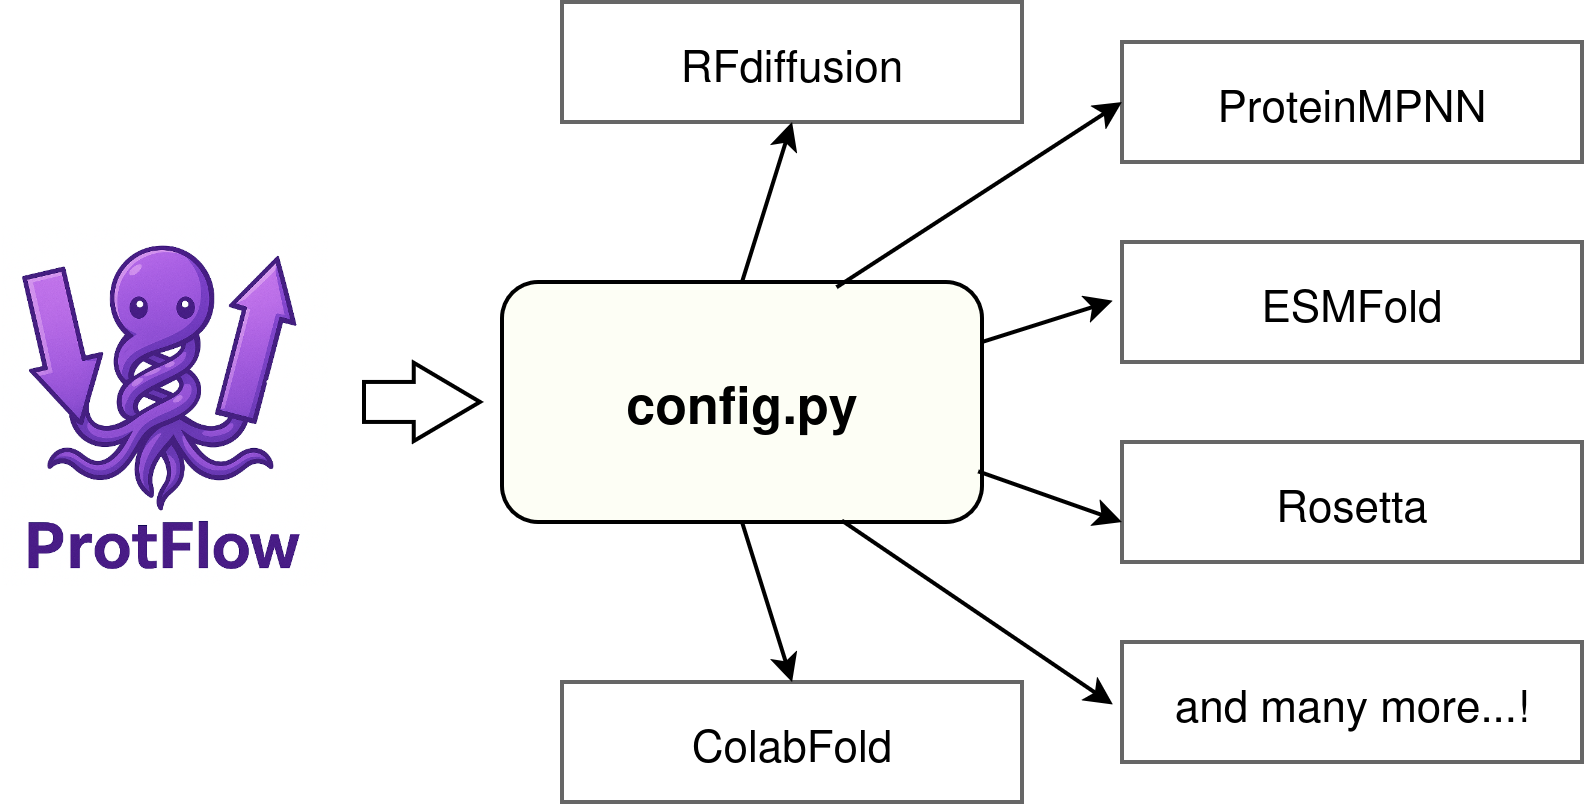

A pipeline similar to this one was used in the Adaptyv Bio's EGRF binder competition round 1 leading to a design ranking on [third place](https://www.adaptyvbio.com/blog/po102/).


In [1]:
# Installation

# ================================
# SYSTEM SETUP AND DEPENDENCIES
# ================================

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✗ Not running in Google Colab")

# Mount Google Drive for persistent storage
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# ================================
# MICROMAMBA ENVIRONMENT SETUP
# ================================
# Install micromamba in Google Colab
!wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba

# Make it easier to call
!mkdir -p /usr/local/bin
!mv bin/micromamba /usr/local/bin/

# set enviorenment variable for micromamba
import os
os.environ['MAMBA_EXE'] = '/usr/local/bin/micromamba'
os.environ['MAMBA_ROOT_PREFIX'] = '/root/micromamba'





✓ Running in Google Colab
Mounted at /content/drive
bin/micromamba


In [9]:

# ================================
# DSSP INSTALL
# ================================
#!apt-get install dssp
#dssp version installed with apt in Sept 2025(dssp 4.0.4-1) is not accepting the pdb files generated, dssp version 4.2.2 does
#precompiled version will be downloaded with the needed library from the git repository

!wget https://raw.githubusercontent.com/mabr3112/ProtFlow/refs/heads/develop/examples/colab_tutorials/files/mkdssp -O /usr/bin/mkdssp
!wget https://raw.githubusercontent.com/mabr3112/ProtFlow/refs/heads/develop/examples/colab_tutorials/files/libcifpp.so.5 -O /usr/lib/x86_64-linux-gnu/libcifpp.so.5
!chmod 755 /usr/bin/mkdssp
print("✓ DSSP complete")


--2025-10-29 14:37:07--  https://raw.githubusercontent.com/mabr3112/ProtFlow/refs/heads/develop/examples/colab_tutorials/files/mkdssp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6017576 (5.7M) [application/octet-stream]
Saving to: ‘/usr/bin/mkdssp’

/usr/bin/mkdssp     100%[===================>]   5.74M  --.-KB/s    in 0.05s   

2025-10-29 14:37:07 (121 MB/s) - ‘/usr/bin/mkdssp’ saved [6017576/6017576]

--2025-10-29 14:37:07--  https://raw.githubusercontent.com/mabr3112/ProtFlow/refs/heads/develop/examples/colab_tutorials/files/libcifpp.so.5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... co

In [3]:
# ================================
# LIGANDMPNN SETUP
# ================================

!git clone https://github.com/dauparas/LigandMPNN.git
%cd LigandMPNN
!bash get_model_params.sh "./model_params"

!micromamba create -y -n ligandmpnn -c conda-forge -c bioconda tmalign  python=3.11 git

!micromamba run -n ligandmpnn pip install -r requirements.txt
%cd /content

print("✓ LigandMPNN setup complete")

Cloning into 'LigandMPNN'...
remote: Enumerating objects: 338, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 338 (delta 120), reused 99 (delta 99), pack-reused 176 (from 1)
Receiving objects: 100% (338/338), 2.64 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/LigandMPNN
[+] 0.0s
[+] 0.1s
[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  
bioconda/linux-64      0%
bioconda/noarch       ⣾  [+] 0.2s
conda-forge/linux-64   2%
conda-forge/noarch     9%
bioconda/linux-64     77%
bioconda/noarch        7%bioconda/linux-64                                 
[+] 0.3s
conda-forge/linux-64   7%
conda-forge/noarch    19%
bioconda/noarch       53%[+] 0.4s
conda-forge/linux-64   7%
conda-forge/noarch    19%
bioconda/noarch       53%[+] 0.5s
conda-forge/linux-64   7%
conda-forge/noarch    24%
bioconda/noarch       53%[+] 0.6s
conda-forge/linux-64   7%
conda-forge/noarch    24%
bioconda/n

In [4]:
# ================================
# BOLTZ SETUP
# ================================

%%bash
# --- Create env ---
micromamba create -y -n boltz python=3.10 -c conda-forge

# --- Install CUDA-enabled PyTorch ---
micromamba install -y -n boltz pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia -c conda-forge

# --- Activate environment and install Boltz + deps ---
micromamba run -n boltz bash -c '
set -e
runtime="GPU(L4 or T4)"
deps="numpy hydra-core pytorch-lightning rdkit dm-tree requests pandas types-requests einops einx fairscale mashumaro modelcif wandb click pyyaml biopython scipy numba gemmi scikit-learn chembl_structure_pipeline cuequivariance_ops_cu12 cuequivariance_ops_torch_cu12 cuequivariance_torch"

if [[ "$runtime" == "GPU(L4 or T4)" ]]; then
  precision="32-true"
else
  precision="bf16-true"
fi

git clone https://github.com/jwohlwend/boltz.git /content/boltz
sed -i "s/bf16-mixed/${precision}/g" /content/boltz/src/boltz/main.py
pip install ipywidgets $deps
#cd /content/boltz && pip install --no-deps -e .
cd /content/boltz && pip install --no-deps .

echo "✅ Boltz environment setup complete."
'

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache


Transaction

  Prefix: /root/micromamba/envs/boltz

  Updating specs:

   - python=3.10


  Package               Version  Build               Channel           Size
─────────────────────────────────────────────────────────────────────────────
  Install:
─────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex           0.1  conda_forge         conda-forge     Cached
  + _openmp_mutex           4.5  2_gnu               conda-forge     Cached
  + bzip2                 1.0.8  hda65f42_8          conda-forge     Cached
  + ca-certificates   2025.10.5  hbd8a1cb_0          conda-forge     Cached
  + ld_impl_linux-64       2.44  h1aa0949_4          conda-forge     Cached
  + libexpat              2.7.1  hecca717_0          conda-forge     Cached
  + libffi                3.5.2  h9ec8514_0          conda-forge

warning  libmamba [libjpeg-turbo-2.0.0-h9bf148f_0] The following files were already present in the environment:
    - bin/cjpeg
    - bin/djpeg
    - bin/jpegtran
    - bin/rdjpgcom
    - bin/wrjpgcom
    - include/jconfig.h
    - include/jerror.h
    - include/jmorecfg.h
    - include/jpeglib.h
    - lib/libjpeg.a
    - lib/libjpeg.so
    - lib/pkgconfig/libjpeg.pc
    - share/man/man1/cjpeg.1
    - share/man/man1/djpeg.1
    - share/man/man1/jpegtran.1
    - share/man/man1/rdjpgcom.1
    - share/man/man1/wrjpgcom.1
Cloning into '/content/boltz'...
  DEPRECATION: Building 'antlr4-python3-runtime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'antlr4-python3-runtime'. Discussion can be found

In [10]:

# ================================
# RFDIFFUSION ENVIROMENT SETUP
# ================================
%cd /content
!wget https://raw.githubusercontent.com/mabr3112/ProtFlow/refs/heads/develop/examples/colab_tutorials/files/environment.yml
!micromamba create -y -f "/content/environment.yml"


print("✓ RFdiffusion setup complete")




Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.1s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.2s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.3s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.4s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.5s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.6s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.7s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.8s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 7.9s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 8.0s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 8.1s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 8.2s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 8.3s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 8.4s
dglteam/linux-64 (..  ⣾  
dglteam/noarch (ch..  ⣾  [+] 8.5s
dglteam/linux-64 (..  ⣾  
dglteam

In [11]:
# ================================
# RFDIFFUSION DOWNLOAD & INSTALL
# ================================

!git clone https://github.com/RosettaCommons/RFdiffusion.git
%cd /content/RFdiffusion
#Get all the needed models
!mkdir -p models
!wget -O models/Base_ckpt.pt https://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt
!wget -O models/Complex_base_ckpt.pt https://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt
!wget -O models/Complex_beta_ckpt.pt http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt
!micromamba run -n SE3nv pip install -e env/SE3Transformer
%cd /content/RFdiffusion/env/SE3Transformer/
!micromamba run -n SE3nv python setup.py install
%cd /content/RFdiffusion
!micromamba run -n SE3nv pip install -e .
%cd /content

print("✓ RFdiffusion setup complete")





fatal: destination path 'RFdiffusion' already exists and is not an empty directory.
/content/RFdiffusion
--2025-10-29 14:41:57--  https://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt
Resolving files.ipd.uw.edu (files.ipd.uw.edu)... 128.95.160.134, 128.95.160.135, 2607:4000:406::160:134, ...
Connecting to files.ipd.uw.edu (files.ipd.uw.edu)|128.95.160.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 483616107 (461M) [application/octet-stream]
Saving to: ‘models/Base_ckpt.pt’

models/Base_ckpt.pt 100%[===================>] 461.21M  21.3MB/s    in 6.9s    

2025-10-29 14:42:03 (67.2 MB/s) - ‘models/Base_ckpt.pt’ saved [483616107/483616107]

--2025-10-29 14:42:04--  https://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt
Resolving files.ipd.uw.edu (files.ipd.uw.edu)... 128.95.160.134, 128.95.160.135, 2607:4000:406::160:134, ...
Connecting to files.ipd.uw.edu (files.ipd.uw.edu)|128.95.160.1

# ProtFlow installation
The following cell will install ProtFlow and create a function to display designed structures. The next cell will set up the [config file](https://github.com/mabr3112/ProtFlow?tab=readme-ov-file#the-configuration-file) for ProtFlow. This config file is how ProtFlow knows where to find protein design tools within your Google Colab Server.

ProtFlow is roughly organized like this:

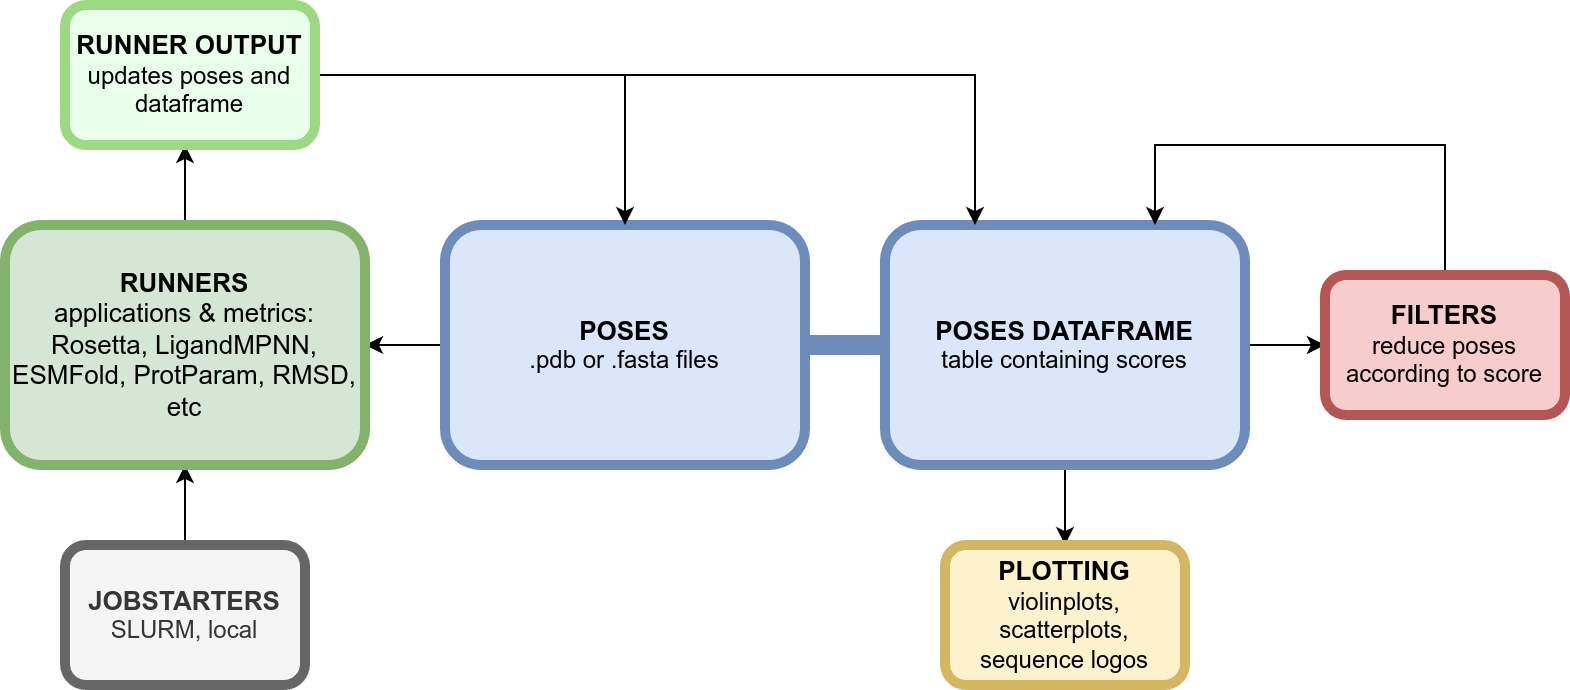

In [12]:
# ================================
# PROTFLOW SETUP
# ================================
import sys, os, site

# Go to workspace
%cd /content
# ProtFlow instalation
#!git clone https://github.com/mabr3112/ProtFlow.git
#%cd ProtFlow
#!/usr/bin/pip3 install -e .
#!pip install -e .
!{sys.executable} -m pip install git+https://github.com/mabr3112/ProtFlow.git


# --- Initialize ProtFlow config ---
!protflow-init-config
#sys.path.append("/content/ProtFlow")
#!ln -sf /usr/bin/python3 /usr/bin/python
%cd /content

# we need a "python" for the protflow config file
!ln -s /usr/bin/python3 /usr/bin/python
#linking TMalign to standard path
!ln -s /root/micromamba/envs/ligandmpnn/bin/TMalign /usr/bin/TMalign


print("✓ ProtFlow setup complete")


/content
  Cloning https://github.com/mabr3112/ProtFlow.git to /tmp/pip-req-build-9ivluqrp
  Running command git clone --filter=blob:none --quiet https://github.com/mabr3112/ProtFlow.git /tmp/pip-req-build-9ivluqrp
  Resolved https://github.com/mabr3112/ProtFlow.git to commit 5236d6ef5659069357f955c3f3ca691ab3e434b0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.7 MB/s eta 0:00:00
  Created wheel for protflow: filename=protflow-0.1.0-py3-none-any.whl size=286030 sha256=bfc4561a47e489ab60070224d71fa02adf7364033e0d1963769941ef4ef3f700
  Stored in directory: /tmp/pip-ephem-wheel-cache-tbzmfqed/wheels/c5/82/29/

In [32]:
%%writefile /root/.config/protflow/config.py
'''
This module contains all paths to tools integrated in ProtFlow. PRE_CMD are commands that should be run before the runner is executed (e.g. if import of a specific module is necessary for the environment to work)
'''
# path to root directory of ProtFlow:
PROTFLOW_DIR = "/content/ProtFlow/"

# protflow environment python
PROTFLOW_ENV = "/usr/bin/" # Corrected path to the base python executable

# auxiliary runners directory path
AUXILIARY_RUNNER_SCRIPTS_DIR = "/usr/local/lib/python3.12/dist-packages/protflow/tools/runners_auxiliary_scripts/"

# protein_generator.py
PROTEIN_GENERATOR_SCRIPT_PATH = "/usr/local/lib/python3.12/dist-packages/protflow/tools/runners_auxiliary_scripts/protein_generator.py"
PROTEIN_GENERATOR_PYTHON_PATH = ""

# ligandmpnn.py
LIGANDMPNN_SCRIPT_PATH =  "/content/LigandMPNN/run.py"
LIGANDMPNN_PYTHON_PATH = "/root/micromamba/envs/ligandmpnn/bin/python"
LIGANDMPNN_PRE_CMD = "" # "echo 'this will be printed before running ligandmpnn'"

# rosetta.py
ROSETTA_BIN_PATH = "" # "/path/to/Rosetta/main/source/bin/"
ROSETTA_PRE_CMD = ""

# attnpacker.py
ATTNPACKER_PYTHON_PATH = "" # "/path/to/anaconda3/envs/attnpacker/bin/python3"
ATTNPACKER_DIR_PATH = "" # "/path/to/AttnPacker/"
ATTNPACKER_PRE_CMD = ""

# rfdiffusion.py
RFDIFFUSION_SCRIPT_PATH = "/content/RFdiffusion/scripts/run_inference.py"
RFDIFFUSION_PYTHON_PATH = "/root/micromamba/envs/SE3nv/bin/python"
RFDIFFUSION_PRE_CMD = ""

# esmfold.py
ESMFOLD_PYTHON_PATH = "" # "/path/to/miniconda3/envs/esm/bin/python"
ESMFOLD_PRE_CMD = ""

# af2
COLABFOLD_SCRIPT_PATH = "" # "/path/to/localcolabfold/colabfold-conda/bin/colabfold_batch"
COLABFOLD_PRE_CMD = ""

# fpocket
FPOCKET_PATH = "" # "/path/to/anaconda3/envs/protslurm/bin/fpocket"

# dssp
DSSP_PATH = "/usr/bin/mkdssp"

# boltz
BOLTZ_PATH = "/root/micromamba/envs/boltz/bin/boltz"
BOLTZ_PYTHON = "/root/micromamba/envs/boltz/bin/python3"
BOLTZ_PRE_CMD = ""

# gromacs
GROMACS_PATH = "" #/path/to/gromacs/bin/

# PLACER
PLACER_SCRIPT_PATH = "" # "/path/to/PLACER/run_PLACER.py"
PLACER_PYTHON_PATH = "" # "/path/to/mambaforge/envs/placer/bin/python"
PLACER_PRE_CMD = ""

# ESM
ESM_PYTHON_PATH = "" # "/path/to/package_manager/envs/your_esm_env/bin/python"
ESM_PRE_CMD = ""

# protein generator
PROTEIN_GENERATOR_PYTHON_PATH = ""
PROTEIN_GENERATOR_SCRIPT_PATH = "/usr/local/lib/python3.12/dist-packages/protflow/tools/runners_auxiliary_scripts/protein_generator.py"

Overwriting /root/.config/protflow/config.py


In [14]:
# ================================
# VIEWER SETUP
# ================================
!pip install py3Dmol biopython

import py3Dmol
import os
from itertools import combinations
import numpy as np
from Bio.PDB import PDBParser, NeighborSearch
import warnings
warnings.filterwarnings('ignore')


def calculate_interface_residues(pdb_data, distance_cutoff=10.0):
    """
    Calculate actual interface residues between chains based on distance.
    """
    try:
        # Write temporary file for BioPython parsing
        with open('temp.pdb', 'w') as f:
            f.write(pdb_data)

        parser = PDBParser(QUIET=True)
        structure = parser.get_structure('temp', 'temp.pdb')

        # Collect atoms per chain
        chain_atoms = {}
        for chain in structure.get_chains():
            chain_id = chain.get_id()
            atoms = []
            for residue in chain:
                for atom in residue:
                    if atom.element != 'H':  # Skip hydrogens
                        atoms.append((atom, residue.get_id()[1], chain_id))
            chain_atoms[chain_id] = atoms

        interface_residues = {}
        chain_ids = list(chain_atoms.keys())

        for i, chain1 in enumerate(chain_ids):
            for chain2 in chain_ids[i+1:]:
                atoms1 = [atom[0] for atom in chain_atoms[chain1]]
                atoms2 = [atom[0] for atom in chain_atoms[chain2]]

                if not atoms1 or not atoms2:
                    continue

                ns = NeighborSearch(atoms1)
                interface_res1, interface_res2 = set(), set()

                for atom in atoms2:
                    neighbors = ns.search(atom.coord, distance_cutoff)
                    if neighbors:
                        for neighbor in neighbors:
                            res_id = neighbor.get_parent().get_id()[1]
                            interface_res1.add(res_id)

                        res_id2 = atom.get_parent().get_id()[1]
                        interface_res2.add(res_id2)

                if interface_res1 and interface_res2:
                    interface_residues[(chain1, chain2)] = {
                        chain1: list(interface_res1),
                        chain2: list(interface_res2)
                    }

        if os.path.exists('temp.pdb'):
            os.remove('temp.pdb')

        return interface_residues
    except Exception as e:
        print(f"Warning: Could not calculate interfaces: {e}")
        return {}


def show_proteins_with_interfaces(pdb_list, width=400, height=400, grid_cols=2,
                                interface_cutoff=5.0, show_interface_surface=True,
                                color_by_plddt=False, highlight_residues=None):
    """
    Display multiple protein structures as cartoon,
    with each chain in a different color (or by pLDDT),
    and highlight inter-chain interfaces using distance cutoff.

    Parameters
    ----------
    pdb_list : list of str
        List of PDB filenames or raw PDB strings.
    width : int
        Width of each viewer.
    height : int
        Height of each viewer.
    grid_cols : int
        Number of columns in the grid layout.
    interface_cutoff : float
        Distance cutoff for interface detection (Angstroms).
    show_interface_surface : bool
        Whether to show surface at interfaces.
    color_by_plddt : bool
        If True, color by B-factor values interpreted as pLDDT scores.
        Uses AlphaFold color scheme: blue (high confidence) to red (low confidence).
    highlight_residues : str or list of str, optional
        Residues to highlight. Can be:
        - A single string like "B18,B39,B41,B108,B131"
        - A list of strings, one per structure: ["B18,B39", "A25,A30"]
        Format: chain_id + residue_number (e.g., "B18" = chain B, residue 18)
    """
    n = len(pdb_list)
    if n == 0:
        print("No PDB files provided!")
        return None

    # Simple chain color palette (expandable)
    chain_colors = [
        "red", "blue", "green", "orange", "purple", "cyan",
        "magenta", "yellow", "brown", "pink", "grey"
    ]

    # Parse highlight_residues
    highlight_list = []
    if highlight_residues is not None:
        if isinstance(highlight_residues, str):
            # Single string for all structures
            highlight_list = [highlight_residues] * n
        elif isinstance(highlight_residues, list):
            # List of strings, one per structure
            highlight_list = highlight_residues + [None] * (n - len(highlight_list))
        else:
            print("Warning: highlight_residues must be a string or list of strings")
            highlight_list = [None] * n
    else:
        highlight_list = [None] * n

    grid_rows = (n + grid_cols - 1) // grid_cols
    view = py3Dmol.view(width=width*grid_cols, height=height*grid_rows,
                        viewergrid=(grid_rows, grid_cols))

    for i, pdb in enumerate(pdb_list):
        try:
            # Load PDB
            if isinstance(pdb, str) and pdb.endswith(".pdb") and os.path.exists(pdb):
                with open(pdb, 'r') as f:
                    pdb_data = f.read()
                title = os.path.basename(pdb)
            else:
                pdb_data = pdb
                title = f"Structure {i+1}"

            row, col = divmod(i, grid_cols)

            # Add model
            view.addModel(pdb_data, "pdb", viewer=(row, col))

            # Detect chains
            chains = set()
            for line in pdb_data.splitlines():
                if line.startswith(("ATOM", "HETATM")):
                    chain_id = line[21].strip()
                    if chain_id:
                        chains.add(chain_id)

            chains = sorted(list(chains))
            print(f"{title}: Found chains {chains}")

            # Color scheme selection
            if color_by_plddt:
                # pLDDT coloring using AlphaFold color scheme
                # pLDDT scale: 0-50 (red), 50-70 (yellow), 70-90 (cyan), 90-100 (blue)
                view.setStyle(
                    {},
                    {"cartoon": {
                        "colorscheme": {
                            "prop": "b",
                            "gradient": "roygb",
                            "min": 0,
                            "max": 100
                        }
                    }},
                    viewer=(row, col)
                )
                print(f"{title}: Colored by pLDDT (B-factor)")
            else:
                # Color each chain distinctly
                for j, chain in enumerate(chains):
                    color = chain_colors[j % len(chain_colors)]
                    view.setStyle(
                        {"chain": chain},
                        {"cartoon": {"color": color}},
                        viewer=(row, col)
                    )
                print(f"{title}: Colored by chain")

            # Highlight interfaces if multiple chains
            if len(chains) > 1:
                interface_residues = calculate_interface_residues(pdb_data, interface_cutoff)
                if interface_residues:
                    print(f"{title}: Found {len(interface_residues)} interface(s)")
                    for (chain1, chain2), residues in interface_residues.items():
                        for chain, res_list in residues.items():
                            for res_num in res_list:
                                view.addStyle(
                                    {"chain": chain, "resi": res_num},
                                    {"stick": {"colorscheme": "redCarbon", "radius": 0.3}},
                                    viewer=(row, col)
                                )
                                if show_interface_surface:
                                    view.addStyle(
                                        {"chain": chain, "resi": res_list},
                                        {"surface": {"opacity": 0.6, "color": "red"}},
                                        viewer=(row, col)
                                    )
                else:
                    print(f"{title}: No interfaces found within {interface_cutoff}Å")

            # Highlight specific residues if provided
            highlight_spec = highlight_list[i]
            if highlight_spec:
                try:
                    # Parse residue specification: "B18,B39,B41,B108,B131"
                    residue_specs = [s.strip() for s in highlight_spec.split(',')]
                    highlighted_count = 0

                    for res_spec in residue_specs:
                        if len(res_spec) < 2:
                            continue

                        # Extract chain (first character) and residue number (rest)
                        chain_id = res_spec[0]
                        try:
                            res_num = int(res_spec[1:])
                        except ValueError:
                            print(f"Warning: Could not parse residue '{res_spec}'")
                            continue

                        # Highlight with sphere and stick representation
                        view.addStyle(
                            {"chain": chain_id, "resi": res_num},
                            {"sphere": {"color": "yellow", "radius": 1.0}},
                            viewer=(row, col)
                        )
                        view.addStyle(
                            {"chain": chain_id, "resi": res_num},
                            {"stick": {"color": "yellow", "radius": 0.5}},
                            viewer=(row, col)
                        )
                        highlighted_count += 1

                    if highlighted_count > 0:
                        print(f"{title}: Highlighted {highlighted_count} residue(s)")

                except Exception as e:
                    print(f"Error highlighting residues for {title}: {e}")

            view.addLabel(title, {"position": {"x": 0, "y": 0, "z": 0},
                                  "backgroundColor": "black", "fontColor": "white"},
                          viewer=(row, col))

            view.zoomTo(viewer=(row, col))

        except Exception as e:
            print(f"Error processing {pdb}: {e}")
            continue

    return view


# ================================
# USAGE EXAMPLES
# ================================

# Example 1: Regular chain coloring
# pdb_files = ["structure1.pdb", "structure2.pdb", "structure3.pdb"]
# viewer = show_proteins_with_interfaces(pdb_files, width=500, height=400, grid_cols=2)
# viewer.show()

# Example 2: pLDDT coloring (for AlphaFold/predicted structures)
# pdb_files = ["alphafold_structure1.pdb", "alphafold_structure2.pdb"]
# viewer = show_proteins_with_interfaces(
#     pdb_files,
#     width=500,
#     height=400,
#     grid_cols=2,
#     color_by_plddt=True
# )
# viewer.show()

# Example 3: Adjust interface cutoff
# viewer = show_proteins_with_interfaces(
#     pdb_files,
#     width=500,
#     height=400,
#     grid_cols=2,
#     interface_cutoff=8.0,  # More permissive interface detection
#     show_interface_surface=False  # Don't show surface
# )
# viewer.show()

# If your pipeline execution in Google Colab was interrupted
If your workflow is interrupted or the connection to your resources is lost, you can continue your pipeline by simply using this code snippet to reload your poses class from your google drive.


```
#import importlib
#import protflow
#importlib.reload(protflow)

from protflow.poses import Poses
output_dir = "drive/MyDrive/ProtFlow_bindertutorial_output/"

poses_instance = Poses()
poses =p oses_instance.load_poses(output_dir+'/ProtFlow_bindertutorial_output_scores.json')
poses.set_work_dir(output_dir)
display(poses.df)
```



# 1. Load a pdb as pose and define hotspot residues

In [22]:
from protflow.poses import Poses
from protflow.residues import residue_selection

#create directory for output on you google drive and copy input pdb for the tutorial
!mkdir -p /content/drive/MyDrive/ProtFlow_bindertutorial_output/
!wget https://raw.githubusercontent.com/TecnomaLaser/ProtFlow-binder-design-tutorial/refs/heads/main/input/egfr_truncated.pdb -O drive/MyDrive/ProtFlow_bindertutorial_output/egfr_truncated.pdb


#define input pdb and output directory
receptor_pdb = "/content/drive/MyDrive/ProtFlow_bindertutorial_output/egfr_truncated.pdb"
output_dir = "/content/drive/MyDrive/ProtFlow_bindertutorial_output"

# import all PDB files in input dir as poses
poses = Poses(poses=receptor_pdb, work_dir=output_dir)

hotspot_residues = "B18,B39,B41,B108,B131" # residue numbers are different in the truncated EGFR!
hotspot_residue_selection = residue_selection(hotspot_residues, delim=",")

# add hotspot residues to poses df
# assign each pose the residue selection of the hotspot residues
poses.df["hotspot_residues_original"] = [hotspot_residue_selection for _ in poses.poses_list()]

# this residue selection will be updated post-diffusion (to track changing residue numbers)
poses.df["hotspot_residues_postdiffusion"] = [hotspot_residue_selection for _ in poses.poses_list()]
display(poses.df)

--2025-10-29 14:44:50--  https://raw.githubusercontent.com/TecnomaLaser/ProtFlow-binder-design-tutorial/refs/heads/main/input/egfr_truncated.pdb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102152 (100K) [text/plain]
Saving to: ‘drive/MyDrive/ProtFlow_bindertutorial_output/egfr_truncated.pdb’

drive/MyDrive/ProtF 100%[===================>]  99.76K  --.-KB/s    in 0.01s   

2025-10-29 14:44:50 (7.81 MB/s) - ‘drive/MyDrive/ProtFlow_bindertutorial_output/egfr_truncated.pdb’ saved [102152/102152]



input_poses  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...   

                                               poses poses_description  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...    egfr_truncated   

                         hotspot_residues_original  \
0  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   

                    hotspot_residues_postdiffusion  
0  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))

The cell below displays the structure of the truncated EGRF receptor. Hotspot residues used for the design of the binder are highlighted as yellow spheres.

In [23]:
pdb_files = poses.df["poses"].to_list()
show_proteins_with_interfaces(
    pdb_files,
    highlight_residues="B18,B39,B41,B108,B131",
    grid_cols=1,
    show_interface_surface=False
)


egfr_truncated.pdb: Found chains ['B']
egfr_truncated.pdb: Colored by chain
egfr_truncated.pdb: Highlighted 5 residue(s)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#2. RFdiffusion (~15 mins)
The next cell will run RFdiffusion to generate protein backbones with a length of 80 residues to bind the target conditioned on our previously selected hotspot residues. For this tutorial we will generate only 5 backbones - for a real binder design campaign, typically between 100-10.000 backbones should generated.

In [24]:
from protflow.utils.biopython_tools import load_structure_from_pdbfile, get_sequence_from_pose
from protflow.jobstarters import LocalJobStarter
from protflow.tools.rfdiffusion import RFdiffusion


# set up jobstarters
jobstarter = LocalJobStarter(max_cores=1)  # set up a jobstarter
rfdiffusion = RFdiffusion(jobstarter=jobstarter)  # set up rfdiffusion

# define diffusion contig (B1-162 is the receptor EGFR, binder should be 80 residues)
contig = "B1-162/0 80-80"
# define path to Beta model (comes with RFdiffusion)
beta_model_path = "/content/RFdiffusion/models/Complex_beta_ckpt.pt"

# rfdiffusion options, same as whenever hen running rfdiffusion on the cmd line
diff_opts = f"diffuser.T=50 'contigmap.contigs=[{contig}]' 'ppi.hotspot_res=[{hotspot_residues}]' inference.ckpt_override_path={beta_model_path}"

# run rfdiffusion
rfdiffusion.run(
    poses=poses,
    prefix='rfdiff',
    num_diffusions=4, # roughly 3 min/per design
    options=diff_opts,
    fail_on_missing_output_poses=False,
    update_motifs=['hotspot_residues_postdiffusion'],
)
display(poses.df)


input_poses  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...   

                                               poses    poses_description  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0001   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0002   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0003   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0004   

                         hotspot_residues_original  \
0  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
1  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
2  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
3  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   

                      hotspot_residues_postdiffusion  rfdiff_plddt  \
0  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.986716   
1  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.986904   
2  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.984997   
3  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.982861   

                                 rfdiff_perres_plddt rfdiff_con_hal_pdb_idx  \
0  [0.92683864, 0.94418055, 0.94747865, 0.9515825...                     []   
1  [0.8856101, 0.91033983, 0.946679, 0.94997275, ...                     []   
2  [0.904204, 0.92767745, 0.96479475, 0.9697302, ...                     []   
3  [0.9176746, 0.9571645, 0.97486633, 0.97787327,...                     []   

  rfdiff_con_ref_pdb_idx rfdiff_sampled_mask  \
0                     []   [B1-162/0, 80-80]   
1                     []   [B1-162/0, 80-80]   
2                     []   [B1-162/0, 80-80]   
3                     []   [B1-162/0, 80-80]   

                      rfdiff_complex_con_hal_pdb_idx  \
0  [(B, 81), (B, 82), (B, 83), (B, 84), (B, 85), ...   
1  [(B, 81), (B, 82), (B, 83), (B, 84), (B, 85), ...   
2  [(B, 81), (B, 82), (B, 83), (B, 84), (B, 85), ...   
3  [(B, 81), (B, 82), (B, 83), (B, 84), (B, 85), ...   

                      rfdiff_complex_con_ref_pdb_idx  \
0  [(B, 1), (B, 2), (B, 3), (B, 4), (B, 5), (B, 6...   
1  [(B, 1), (B, 2), (B, 3), (B, 4), (B, 5), (B, 6...   
2  [(B, 1), (B, 2), (B, 3), (B, 4), (B, 5), (B, 6...   
3  [(B, 1), (B, 2), (B, 3), (B, 4), (B, 5), (B, 6...   

                                    rfdiff_input_pdb   rfdiff_description  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0001   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0002   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0003   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0004   

                                     rfdiff_location  
0  /content/drive/MyDrive/ProtFlow_bindertutorial...  
1  /content/drive/MyDrive/ProtFlow_bindertutorial...  
2  /content/drive/MyDrive/ProtFlow_bindertutorial...  
3  /content/drive/MyDrive/ProtFlow_bindertutorial...

In [25]:
pdb_files = poses.df["poses"].to_list()
show_proteins_with_interfaces(pdb_files, width=500, height=400, grid_cols=2, show_interface_surface=True)

egfr_truncated_0001.pdb: Found chains ['A', 'B']
egfr_truncated_0001.pdb: Colored by chain
egfr_truncated_0001.pdb: No interfaces found within 5.0Å
egfr_truncated_0002.pdb: Found chains ['A', 'B']
egfr_truncated_0002.pdb: Colored by chain
egfr_truncated_0002.pdb: No interfaces found within 5.0Å
egfr_truncated_0003.pdb: Found chains ['A', 'B']
egfr_truncated_0003.pdb: Colored by chain
egfr_truncated_0003.pdb: Found 1 interface(s)
egfr_truncated_0004.pdb: Found chains ['A', 'B']
egfr_truncated_0004.pdb: Colored by chain
egfr_truncated_0004.pdb: Found 1 interface(s)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# 3. Filtering generated backbones for subsequent sequence design
Before we design sequences, we will filter the generated backbones based on a selection of backbone quality metrics. These include the number of contacting residues at the interface, the radius of gyration (ROG) to select for "compactness" of the diffused scaffold, and loop content calculated using DSSP to favor structured binders over unstructured ones. We can plot the scores calculated in ProtFlow with ProtFlow's built-in plotting functions.

In [26]:
from protflow.metrics.dssp import DSSP
from protflow.metrics.ligand import LigandContacts
from protflow.metrics.generic_metric_runner import GenericMetric
from protflow.residues import residue_selection # Import ResidueSelection

# set up metrics to calculate scores
contacts = LigandContacts( # calculates number of C-alpha atoms within 10 Angstrom of any atom that is on chain B
    ligand_chain="B",
    min_dist=0,
    max_dist=10,
    atoms=['CA'],
    jobstarter=jobstarter
)

# the generic metric runner can run any function that takes a pose as input using a jobstarter

# Explicitly set python_path for GenericMetric to use the protflow environment
rog_calculator = GenericMetric( # calculates radius of gyration for chain A
    module="protflow.utils.metrics",
    function="calc_rog_of_pdb",
    options={"chain": "A"},
    jobstarter=jobstarter
)

# Explicitly set python_path for GenericMetric to use the protflow environment
rescontacts_calculator = GenericMetric( # calculates number of atoms/residues that are within a certain distance from a target atom or residue
    module="protflow.utils.metrics",
    function="residue_contacts",
    jobstarter=jobstarter
)
dssp = DSSP(jobstarter=jobstarter) # calculates secondary structure content

# retrieve updated hotspot residues (same for all diffused backbones, as length of diffused backbones is always 80 residues)
hotspot_residues_postdiffusion = poses.df["hotspot_residues_original"].iloc[0]

# calculate rog, general contacts and hotspot contacts
rog_calculator.run(poses=poses, prefix="rfdiff_rog") # calculate ROG
contacts.run(poses=poses, prefix="rfdiff_contacts", normalize_by_num_atoms=False) # calculate number of contacts between chain A and B
dssp.run(poses=poses, prefix="dssp") # determine secondary structure content

# calculate number of contacts for each hotspot residue
for res in hotspot_residues_postdiffusion.to_list(): # iterate over hotspot residues
   chain, resnum = [res[0], res[1:]] # extract chain and residue number
   rescontact_opts={"max_distance": 12, "target_chain": chain, "partner_chain": "A", "target_resnum": int(resnum), "target_atom_names": ["CA"], "partner_atom_names": ["CA"]} # define options
   print (rescontact_opts)
   rescontacts_calculator.run(poses=poses, prefix=f"hotspot_{res}_contacts", options=rescontact_opts)

# calculate overall hotspot contacts
poses.df["hotspot_contacts"] = sum([poses.df[f"hotspot_{res}_contacts_data"] for res in hotspot_residues_postdiffusion.to_list()])

{'max_distance': 12, 'target_chain': 'B', 'partner_chain': 'A', 'target_resnum': 18, 'target_atom_names': ['CA'], 'partner_atom_names': ['CA']}
{'max_distance': 12, 'target_chain': 'B', 'partner_chain': 'A', 'target_resnum': 39, 'target_atom_names': ['CA'], 'partner_atom_names': ['CA']}
{'max_distance': 12, 'target_chain': 'B', 'partner_chain': 'A', 'target_resnum': 41, 'target_atom_names': ['CA'], 'partner_atom_names': ['CA']}
{'max_distance': 12, 'target_chain': 'B', 'partner_chain': 'A', 'target_resnum': 108, 'target_atom_names': ['CA'], 'partner_atom_names': ['CA']}
{'max_distance': 12, 'target_chain': 'B', 'partner_chain': 'A', 'target_resnum': 131, 'target_atom_names': ['CA'], 'partner_atom_names': ['CA']}


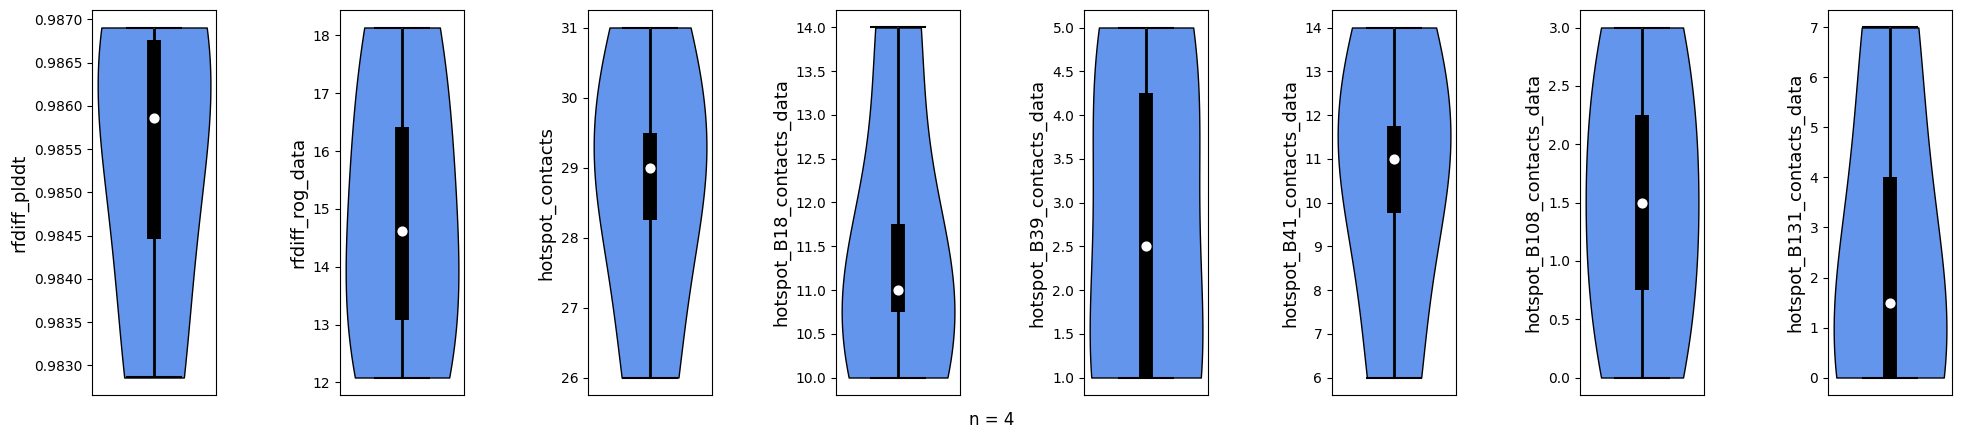

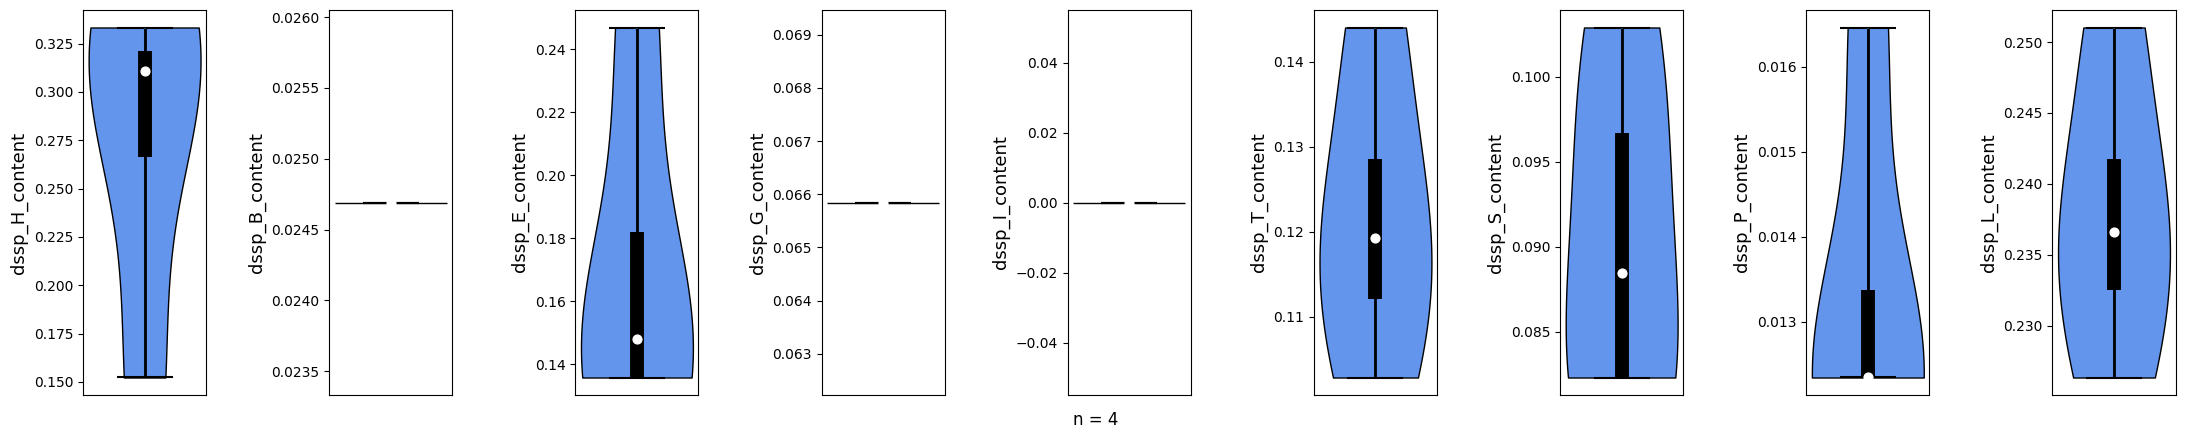

In [28]:
from protflow.utils.plotting import violinplot_multiple_cols

# make a plot of the hotspot_contacts
cols_contact = ["rfdiff_plddt" , "rfdiff_rog_data", "hotspot_contacts"] + [f"hotspot_{res[0]}{res[1:]}_contacts_data" for res in hotspot_residues_postdiffusion.to_list()] # show contacts for each individual hotspot residue
violinplot_multiple_cols(
    dataframe=poses.df,
    cols=cols_contact,
    y_labels=cols_contact,
    out_path=os.path.join(poses.plots_dir, "diff_contacts.png")
)

# make a plot of the secondary structure content
ss_content_cols = [col for col in poses.df.columns if col.startswith("dssp") and col.endswith("content")] # show content for each secondary structure element
violinplot_multiple_cols(
    dataframe=poses.df,
    cols=ss_content_cols,
    y_labels=ss_content_cols,
    out_path=os.path.join(poses.plots_dir, "diff_ss_content.png")
)

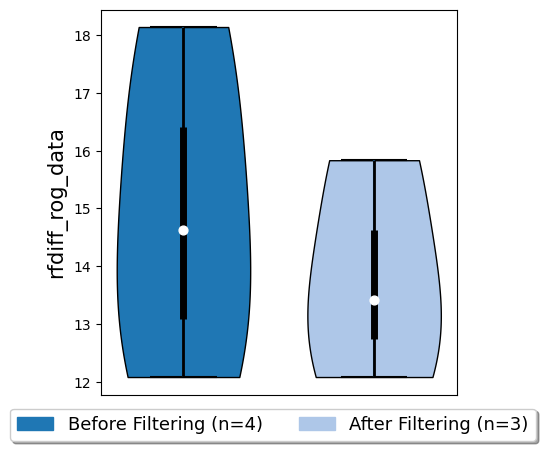

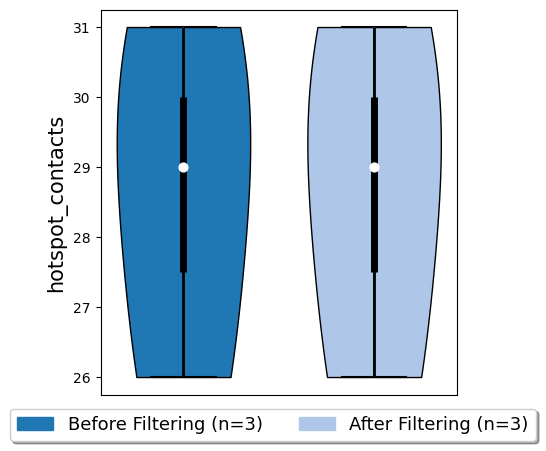

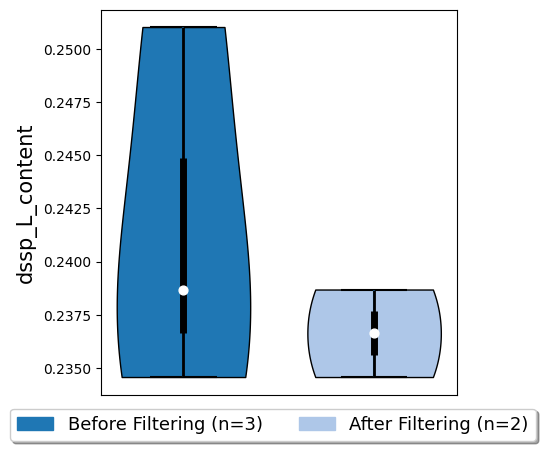

In [29]:
# we filter poses by the given criteria
poses.filter_poses_by_value(score_col="rfdiff_rog_data", value=18, operator="<=", prefix="rfdiff_rog", plot=True) # remove all poses with ROG higher than 20
poses.filter_poses_by_value(score_col="hotspot_contacts", value=20, operator=">=", prefix="rfdiff_hotspots_contacts", plot=True) # remove all poses with fewer total contacts to hotspot residues than the set cutoff
poses.filter_poses_by_value(score_col="dssp_L_content", value = 0.25, operator="<", prefix = "L_content", plot = True) # remove all poses with more than 25% unordered (L) regions


Display selected backbones

In [30]:
pdb_files = poses.df["poses"].to_list()
show_proteins_with_interfaces(pdb_files, width=500, height=400, grid_cols=2, show_interface_surface=True)

egfr_truncated_0001.pdb: Found chains ['A', 'B']
egfr_truncated_0001.pdb: Colored by chain
egfr_truncated_0001.pdb: No interfaces found within 5.0Å
egfr_truncated_0003.pdb: Found chains ['A', 'B']
egfr_truncated_0003.pdb: Colored by chain
egfr_truncated_0003.pdb: Found 1 interface(s)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#4. Sequence design
We use LigandMPNN with the SolubleMPNN model to design sequences for the selected backbones.

In [33]:
from protflow.tools.ligandmpnn import LigandMPNN

ligandmpnn = LigandMPNN(jobstarter=jobstarter)
cycle = 1

# rfdiffusion outputs continous residue numbers over chains, so our 162-AA receptor ranges from residue 81 to 243
# since the last value in a range is not included the range is from 81 to 244
fixed_residues = ' '.join([f'B{i}' for i in range(81, 244)])
mpnn_opts = f"--fixed_residues {fixed_residues}"

# we create 2 sequenes per pose, and return the PDBs with the sequences threaded on the structures instead of the .fasta files
# the receptor chain residues are kept fixed (mpnn_opts)
ligandmpnn.run(
    poses=poses,
    prefix=f"cycle_{cycle}_seq_thread",
    nseq=2,
    model_type="soluble_mpnn",
    options=mpnn_opts,
    return_seq_threaded_pdbs_as_pose=True
)


In [34]:
display(poses.df)

input_poses  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...   

                                               poses  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...   

          poses_description                        hotspot_residues_original  \
0  egfr_truncated_0001_0001  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
1  egfr_truncated_0001_0002  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
2  egfr_truncated_0003_0001  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
3  egfr_truncated_0003_0002  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   

                      hotspot_residues_postdiffusion  rfdiff_plddt  \
0  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.986716   
1  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.986716   
2  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.984997   
3  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.984997   

                                 rfdiff_perres_plddt rfdiff_con_hal_pdb_idx  \
0  [0.92683864, 0.94418055, 0.94747865, 0.9515825...                     []   
1  [0.92683864, 0.94418055, 0.94747865, 0.9515825...                     []   
2  [0.904204, 0.92767745, 0.96479475, 0.9697302, ...                     []   
3  [0.904204, 0.92767745, 0.96479475, 0.9697302, ...                     []   

  rfdiff_con_ref_pdb_idx rfdiff_sampled_mask  ...  \
0                     []   [B1-162/0, 80-80]  ...   
1                     []   [B1-162/0, 80-80]  ...   
2                     []   [B1-162/0, 80-80]  ...   
3                     []   [B1-162/0, 80-80]  ...   

  cycle_1_seq_thread_mpnn_origin cycle_1_seq_thread_seed  \
0            egfr_truncated_0001                 21014.0   
1            egfr_truncated_0001                 21014.0   
2            egfr_truncated_0003                 21014.0   
3            egfr_truncated_0003                 21014.0   

  cycle_1_seq_thread_description  \
0       egfr_truncated_0001_0001   
1       egfr_truncated_0001_0002   
2       egfr_truncated_0003_0001   
3       egfr_truncated_0003_0002   

                         cycle_1_seq_thread_sequence cycle_1_seq_thread_T  \
0  MEELKKKLDEMIDKGEDYSSIKLYLLERYLEYLPESEELKRAIEKI...                  0.1   
1  MEKLKKEIDEMIEKGEDYTKIKLYYLERLKEYLPESKEIDRAIEKL...                  0.1   
2  MMSQEELDREMEALQATDVAALAEIEAAAAAVRAEEDVDGVLEEAK...                  0.1   
3  MMSEEEIEEEMKRLQEIEVAAKEEIEAAKKKVLEEEDVDSLLEELK...                  0.1   

   cycle_1_seq_thread_id cycle_1_seq_thread_seq_rec  \
0                    1.0                     0.2500   
1                    2.0                     0.3000   
2                    1.0                     0.2875   
3                    2.0                     0.2812   

  cycle_1_seq_thread_overall_confidence cycle_1_seq_thread_ligand_confidence  \
0                                0.4030                               0.4030   
1                                0.4010                               0.4010   
2                                0.4256                               0.4256   
3                                0.4175                               0.4175   

                         cycle_1_seq_thread_location  
0  /content/drive/MyDrive/ProtFlow_bindertutorial...  
1  /content/drive/MyDrive/ProtFlow_bindertutorial...  
2  /content/drive/MyDrive/ProtFlow_bindertutorial...  
3  /content/drive/MyDrive/ProtFlow_bindertutorial...  

[4 rows x 59 columns]

#5. Structure prediction
We predict the designed sequences using Boltz and plot the results. The per-residue pLLDT is depicted in the displayed structures.

* *confidence_score*: Aggregated score used to sort the predictions, corresponds to 0.8 * complex_plddt + 0.2 * iptm (ptm for single chains)
* *ptm*: Predicted TM score for the complex
* *iptm*: Predicted TM score when aggregating at the interfaces
* *protein_iptm*: ipTM but only aggregating at protein-protein interfaces
* *complex_plddt*: Average pLDDT score for the complex
* *complex_iplddt*: Average pLDDT score when upweighting interface tokens
* *complex_pde*: Average PDE score for the complex
* *complex_ipde*: Average PDE score when aggregating at interfaces  
* *chains_ptm*: Predicted TM score within each chain
* *pair_chains_iptm*: Predicted (interface) TM score between each pair of chains

In [35]:
from protflow.tools.boltz import Boltz
from protflow.jobstarters import LocalJobStarter

## Now, when running Boltz, simply add the params object to the run() call:
boltz = Boltz()
boltz.run(
    jobstarter=jobstarter,
    poses=poses,
    prefix=f"cycle_{cycle}_boltz",
    options = "--output_format pdb --diffusion_samples 1 --no_kernels --use_msa_server"
)

In [36]:
pdb_files = poses.df["poses"].to_list()
show_proteins_with_interfaces(
    pdb_files,
    width=500,
    height=400,
    grid_cols=2,
    show_interface_surface=True,
    color_by_plddt=True
)

egfr_truncated_0001_0001_model_0.pdb: Found chains ['A', 'B']
egfr_truncated_0001_0001_model_0.pdb: Colored by pLDDT (B-factor)
egfr_truncated_0001_0001_model_0.pdb: Found 1 interface(s)
egfr_truncated_0001_0002_model_0.pdb: Found chains ['A', 'B']
egfr_truncated_0001_0002_model_0.pdb: Colored by pLDDT (B-factor)
egfr_truncated_0001_0002_model_0.pdb: Found 1 interface(s)
egfr_truncated_0003_0001_model_0.pdb: Found chains ['A', 'B']
egfr_truncated_0003_0001_model_0.pdb: Colored by pLDDT (B-factor)
egfr_truncated_0003_0001_model_0.pdb: Found 1 interface(s)
egfr_truncated_0003_0002_model_0.pdb: Found chains ['A', 'B']
egfr_truncated_0003_0002_model_0.pdb: Colored by pLDDT (B-factor)
egfr_truncated_0003_0002_model_0.pdb: Found 1 interface(s)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [37]:
import pandas as pd
pd.options.display.max_columns = None
display(poses.df)

input_poses  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...   

                                               poses  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...   

                  poses_description  \
0  egfr_truncated_0001_0001_model_0   
1  egfr_truncated_0001_0002_model_0   
2  egfr_truncated_0003_0001_model_0   
3  egfr_truncated_0003_0002_model_0   

                         hotspot_residues_original  \
0  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
1  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
2  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   
3  ((B, 18), (B, 39), (B, 41), (B, 108), (B, 131))   

                      hotspot_residues_postdiffusion  rfdiff_plddt  \
0  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.986716   
1  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.986716   
2  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.984997   
3  ((B, 98), (B, 119), (B, 121), (B, 188), (B, 211))      0.984997   

                                 rfdiff_perres_plddt rfdiff_con_hal_pdb_idx  \
0  [0.92683864, 0.94418055, 0.94747865, 0.9515825...                     []   
1  [0.92683864, 0.94418055, 0.94747865, 0.9515825...                     []   
2  [0.904204, 0.92767745, 0.96479475, 0.9697302, ...                     []   
3  [0.904204, 0.92767745, 0.96479475, 0.9697302, ...                     []   

  rfdiff_con_ref_pdb_idx rfdiff_sampled_mask  \
0                     []   [B1-162/0, 80-80]   
1                     []   [B1-162/0, 80-80]   
2                     []   [B1-162/0, 80-80]   
3                     []   [B1-162/0, 80-80]   

                      rfdiff_complex_con_hal_pdb_idx  \
0  [(B, 81), (B, 82), (B, 83), (B, 84), (B, 85), ...   
1  [(B, 81), (B, 82), (B, 83), (B, 84), (B, 85), ...   
2  [(B, 81), (B, 82), (B, 83), (B, 84), (B, 85), ...   
3  [(B, 81), (B, 82), (B, 83), (B, 84), (B, 85), ...   

                      rfdiff_complex_con_ref_pdb_idx  \
0  [(B, 1), (B, 2), (B, 3), (B, 4), (B, 5), (B, 6...   
1  [(B, 1), (B, 2), (B, 3), (B, 4), (B, 5), (B, 6...   
2  [(B, 1), (B, 2), (B, 3), (B, 4), (B, 5), (B, 6...   
3  [(B, 1), (B, 2), (B, 3), (B, 4), (B, 5), (B, 6...   

                                    rfdiff_input_pdb   rfdiff_description  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0001   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0001   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0003   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...  egfr_truncated_0003   

                                     rfdiff_location  rfdiff_rog_data  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...        13.415867   
1  /content/drive/MyDrive/ProtFlow_bindertutorial...        13.415867   
2  /content/drive/MyDrive/ProtFlow_bindertutorial...        15.832564   
3  /content/drive/MyDrive/ProtFlow_bindertutorial...        15.832564   

  rfdiff_rog_description                                rfdiff_rog_location  \
0    egfr_truncated_0001  /content/drive/MyDrive/ProtFlow_bindertutorial...   
1    egfr_truncated_0001  /content/drive/MyDrive/ProtFlow_bindertutorial...   
2    egfr_truncated_0003  /content/drive/MyDrive/ProtFlow_bindertutorial...   
3    egfr_truncated_0003  /content/drive/MyDrive/ProtFlow_bindertutorial...   

  rfdiff_contacts_description  \
0         egfr_truncated_0001   
1         egfr_truncated_0001   
2         egfr_truncated_0003   
3         egfr_truncated_0003   

                            rfdiff_contacts_location  \
0  /content/drive/MyDrive/ProtFlow_bindertutorial...   
1  /content/drive/MyDrive/ProtFlow_b

We calculate the rmsd as well as the template modeling score ([TM score](https://en.wikipedia.org/wiki/Template_modeling_score)) of the predictions compared to the RFdiffusion backbones.

In [38]:
from protflow.metrics.rmsd import BackboneRMSD
from protflow.metrics.tmscore import TMalign

# Initialize the BackboneRMSD class
backbone_rmsd = BackboneRMSD(jobstarter=jobstarter)

# Run the RMSD calculation
results = backbone_rmsd.run(
    poses=poses,
    prefix=f"cycle_{cycle}",
    ref_col="rfdiff_location",
    chains=["A", "B"],
    overwrite=True
)

# calculate tm score between prediction and relaxed pose
tmalign = TMalign(jobstarter=jobstarter)
tmalign.run(poses=poses, prefix=f"cycle_{cycle}_tm", ref_col=f"rfdiff_location")

Let's compare the calculated TM score with the rmsd.

In [39]:
display(poses.df[["cycle_1_rmsd","cycle_1_tm_TM_score_pose"]])

cycle_1_rmsd  cycle_1_tm_TM_score_pose
0      6.301763                   0.86670
1     10.813366                   0.83613
2      7.633848                   0.75642
3      8.509136                   0.51172

Let' plot the these results as scatterplot:

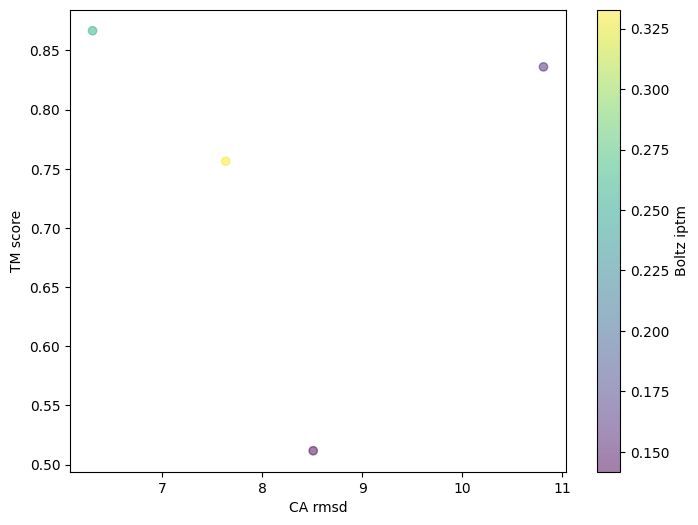

In [40]:
from protflow.utils.plotting import scatterplot, violinplot_multiple_cols

scatterplot(dataframe=poses.df, x_column='cycle_1_rmsd', y_column='cycle_1_tm_TM_score_pose', labels=['CA rmsd', 'TM score', 'Boltz iptm'], color_column='cycle_1_boltz_iptm', out_path=output_dir+'/plots/tm_vs_rmsd_scatterplot.png')

Plot all the results:

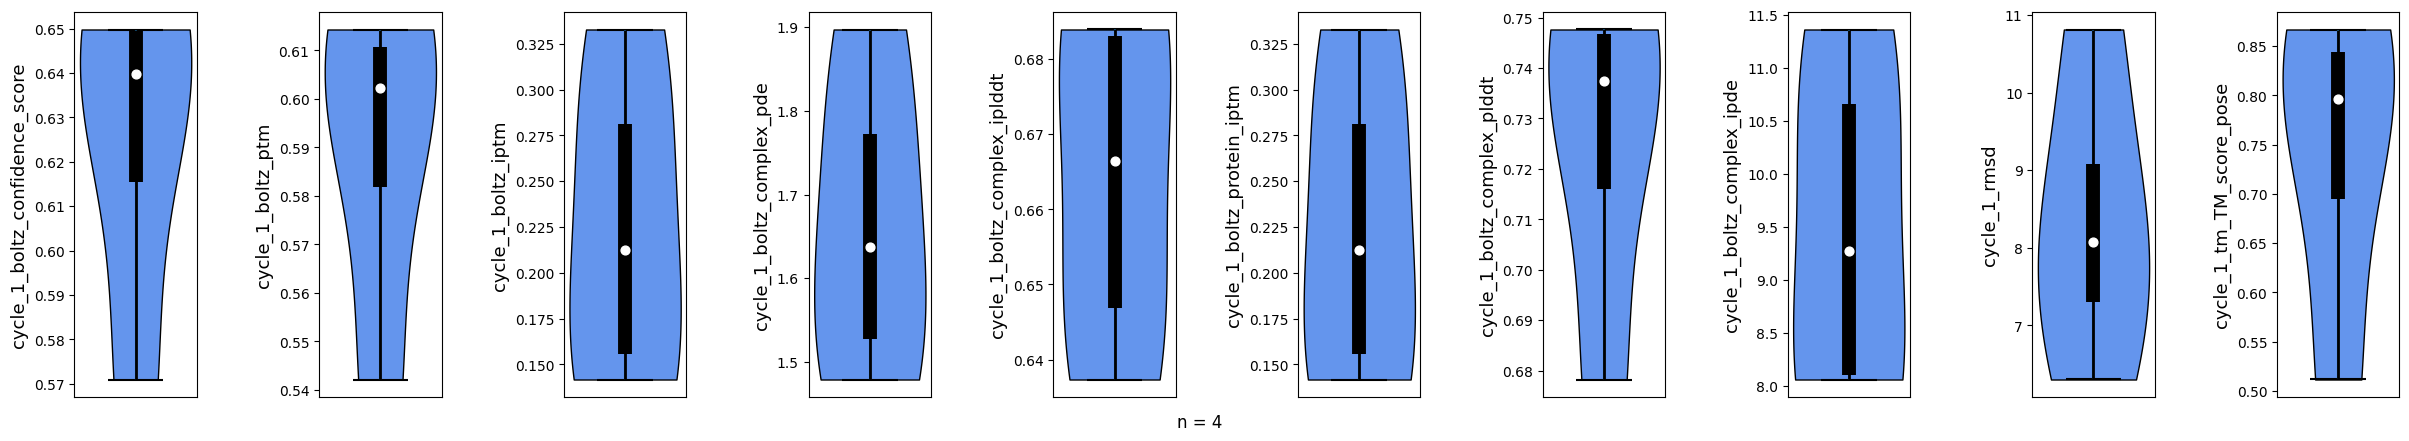

In [41]:
boltz_statistics = [
    "cycle_1_boltz_confidence_score", "cycle_1_boltz_ptm", "cycle_1_boltz_iptm", "cycle_1_boltz_complex_pde",
    "cycle_1_boltz_complex_iplddt", "cycle_1_boltz_protein_iptm", "cycle_1_boltz_complex_plddt",
    "cycle_1_boltz_complex_ipde", "cycle_1_rmsd", "cycle_1_tm_TM_score_pose"
]

violinplot_multiple_cols(
    dataframe=poses.df,
    cols=boltz_statistics,
    y_labels=boltz_statistics,
    out_path=os.path.join(poses.plots_dir+"cycle_1_boltz.png")
)



#6. Cycles
This process had to be iterated in cycles using a energy minimization (Rosetta Relax) after sequence design to improve backbone quality. This step was ommited due to time reasons.